In [40]:
# Imports & settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from pandas.api.types import is_numeric_dtype, is_object_dtype
from IPython.display import Markdown, display

sns.set(style="whitegrid")
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)


In [5]:
df = pd.read_csv("recipe_reviews.csv")

print("Shape of dataset:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape of dataset: (18182, 24)
Columns: ['Unnamed: 0', 'recipe_number', 'recipe_code', 'likes_score', 'dislike_index', 'response_level', 'user_index', 'ranking_value', 'vote_ratio', 'score_log', 'region', 'device_type', 'recipe_name', 'comment_id', 'user_id', 'user_name', 'user_score', 'created_at', 'responses', 'likes', 'dislikes', 'ranking_score', 'text', 'stars']


,Unnamed: 0,recipe_number,recipe_code,likes_score,dislike_index,response_level,user_index,ranking_value,vote_ratio,score_log,region,device_type,recipe_name,comment_id,user_id,user_name,user_score,created_at,responses,likes,dislikes,ranking_score,text,stars
0,0,1,14299,0.104335,-0.087082,-0.001580,1.172032,539.698328,0.000000,0.693147,North,Tablet,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,527,"I tweaked it a little, removed onions because ...",5
1,1,1,14299,6.970958,-0.094496,-0.002169,50.629458,720.511995,0.875000,3.931826,West,Mobile,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,724,Bush used to have a white chili bean and it ma...,5
2,2,1,14299,3.136047,-0.047194,0.014539,10.742998,717.194563,0.750000,2.397895,North,Desktop,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,710,I have a very complicated white chicken chili ...,5
3,3,1,14299,2.319913,-0.107932,2.012194,0.865812,585.875342,0.666667,0.693147,South,Tablet,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,581,"In your introduction, you mentioned cream chee...",0
4,4,1,14299,6.950816,0.142649,1.009770,8.985971,815.148751,0.875000,2.397895,North,Desktop,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...,0


In [6]:
#Quick initial inspection
print("\n--- Initial dtypes ---")
print(df.dtypes)
print("\n--- Missing value counts (initial) ---")
print(df.isna().sum())


--- Initial dtypes ---
Unnamed: 0          int64
recipe_number       int64
recipe_code         int64
likes_score       float64
dislike_index     float64
response_level    float64
user_index        float64
ranking_value     float64
vote_ratio        float64
score_log         float64
region             object
device_type        object
recipe_name        object
comment_id         object
user_id            object
user_name          object
user_score          int64
created_at          int64
responses           int64
likes               int64
dislikes            int64
ranking_score       int64
text               object
stars               int64
dtype: object

--- Missing value counts (initial) ---
Unnamed: 0        0
recipe_number     0
recipe_code       0
likes_score       0
dislike_index     0
response_level    0
user_index        0
ranking_value     0
vote_ratio        0
score_log         0
region            0
device_type       0
recipe_name       0
comment_id        0
user_id           

In [8]:
# 4) Identify rating column robustly
def find_rating_col(df):
    candidates = ['rating', 'stars', 'star_rating', 'rating_stars', 'review_rating']
    for c in candidates:
        if c in df.columns:
            return c
    # fallback: find a numeric column with small integer cardinality 1..5
    for col in df.select_dtypes(include=[np.number]).columns:
        unique_vals = df[col].dropna().unique()
        if set(unique_vals).issubset({1,2,3,4,5}) or (df[col].dropna().between(1,5).all() and df[col].nunique()<=5):
            return col
    # fallback: find a column with <=7 unique values and all integers from 1..5 appear in subset
    for col in df.columns:
        if df[col].nunique() <= 7:
            vals = set(pd.to_numeric(df[col], errors='coerce').dropna().astype(int).unique())
            if {1,2,3,4,5}.intersection(vals):
                return col
    return None
rating_col = find_rating_col(df)
if rating_col is None:
    raise ValueError("Could not detect the rating column automatically. Please ensure your file contains a rating column.")
else:
    print(f"Detected rating column: '{rating_col}'")
# rename rating column consistently
df = df.rename(columns={rating_col: 'rating'})
rating_col = 'rating'

Detected rating column: 'stars'


In [11]:
text_cols = []
if 'review' in df.columns:
    text_cols.append('review')

print("\nReplacing placeholder '2' with NaN in non-text columns...")
for col in df.columns:
    if col in text_cols:
        continue
    if is_numeric_dtype(df[col]):
        mask = df[col] == 2
        n = mask.sum()
        if n > 0:
            print(f"  - Numeric column '{col}': replacing {int(n)} exact 2's -> NaN")
            df.loc[mask, col] = np.nan
    elif is_object_dtype(df[col]):
        mask = df[col].astype(str).str.strip() == '2'
        n = mask.sum()
        if n > 0:
            print(f"  - Categorical column '{col}': replacing {int(n)} exact '2' strings -> NaN")
            df.loc[mask, col] = np.nan

print("\nMissing value counts (after placeholder replacement):")
print(df.isna().sum())

# -------




Replacing placeholder '2' with NaN in non-text columns...

Missing value counts (after placeholder replacement):
Unnamed: 0        100
recipe_number     509
recipe_code         0
likes_score         0
dislike_index       0
response_level      0
user_index          0
ranking_value       0
vote_ratio          0
score_log           0
region              0
device_type         0
recipe_name         0
comment_id          0
user_id             0
user_name           0
user_score          0
created_at          0
responses          24
likes             624
dislikes          388
ranking_score       0
text                2
rating            232
dtype: int64


In [12]:
# Drop duplicates
n_dups = df.duplicated().sum()
print(f"\nFound {int(n_dups)} duplicate rows. Dropping duplicates...")
df = df.drop_duplicates().reset_index(drop=True)
print("Shape after dropping duplicates:", df.shape)



Found 0 duplicate rows. Dropping duplicates...
Shape after dropping duplicates: (18182, 24)


In [13]:
# 7) Normalize categorical text values & dtypes
print("\nNormalizing categorical text values...")

for col in df.columns:
    if col in text_cols:
        df[col] = df[col].astype(str)
        continue
    if 'date' in col.lower() or 'time' in col.lower():
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"  - Converted '{col}' to datetime")
        continue
    if is_object_dtype(df[col]):
        df[col] = df[col].astype(str).str.strip().str.lower().replace({'nan': np.nan, 'none': np.nan, 'na': np.nan})
        coerced = pd.to_numeric(df[col], errors='coerce')
        if coerced.notna().sum() / max(1, len(coerced)) > 0.6:
            df[col] = coerced
            print(f"  - Coerced '{col}' to numeric")
        else:
            df[col] = df[col].astype('category')

df['rating'] = pd.to_numeric(df['rating'], errors='coerce').round().astype('Int64')

print("\nDtypes after normalization:")
print(df.dtypes)




Normalizing categorical text values...

Dtypes after normalization:
Unnamed: 0         float64
recipe_number      float64
recipe_code          int64
likes_score        float64
dislike_index      float64
response_level     float64
user_index         float64
ranking_value      float64
vote_ratio         float64
score_log          float64
region            category
device_type       category
recipe_name       category
comment_id        category
user_id           category
user_name         category
user_score           int64
created_at           int64
responses          float64
likes              float64
dislikes           float64
ranking_score        int64
text              category
rating               Int64
dtype: object


In [14]:
# 8) Handle missing values
print("\nHandling missing values...")
numeric_cols = [c for c in df.columns if is_numeric_dtype(df[c]) and c != 'rating']
cat_cols = [c for c in df.columns if (str(df[c].dtype) in ['category','object']) and c not in text_cols]

for col in numeric_cols:
    median = df[col].median()
    df[col] = df[col].fillna(median)
    print(f"  - Filled numeric '{col}' with median {median}")

for col in cat_cols:
    mode = df[col].mode(dropna=True)[0]
    df[col] = df[col].fillna(mode)
    print(f"  - Filled categorical '{col}' with mode '{mode}'")

for t in text_cols:
    df[t] = df[t].fillna("")



Handling missing values...
  - Filled numeric 'Unnamed: 0' with median 92.0
  - Filled numeric 'recipe_number' with median 34.0
  - Filled numeric 'recipe_code' with median 14600.0
  - Filled numeric 'likes_score' with median 0.0787968988555835
  - Filled numeric 'dislike_index' with median 0.02924607740227325
  - Filled numeric 'response_level' with median 0.0001926399233552
  - Filled numeric 'user_index' with median 1.0407082498093705
  - Filled numeric 'ranking_value' with median 102.66096367500995
  - Filled numeric 'vote_ratio' with median 0.0
  - Filled numeric 'score_log' with median 0.6931471805599453
  - Filled numeric 'user_score' with median 1.0
  - Filled numeric 'created_at' with median 1622717707.0
  - Filled numeric 'responses' with median 0.0
  - Filled numeric 'likes' with median 0.0
  - Filled numeric 'dislikes' with median 0.0
  - Filled numeric 'ranking_score' with median 100.0
  - Filled categorical 'region' with mode 'west'
  - Filled categorical 'device_type' w

In [15]:
# Feature engineering
print("\nFeature engineering...")

def get_word_count(s):
    words = s.split()
    return len(words)

def get_avg_word_length(s):
    words = s.split()
    if len(words) > 0:
        return np.mean([len(w) for w in words])
    else:
        return 0

def get_punctuation_count(s):
    punctuations = '.,;:!?()[]{}"\''
    count = 0
    for ch in s:
        if ch in punctuations:
            count += 1
    return count

if 'review' in df.columns:
    df['review_text'] = df['review'].astype(str)
    df['review_length'] = df['review_text'].apply(str.__len__)   # built-in len
    df['word_count'] = df['review_text'].apply(get_word_count)
    df['avg_word_length'] = df['review_text'].apply(get_avg_word_length)
    df['punctuation_count'] = df['review_text'].apply(get_punctuation_count)
    df['exclamation_flag'] = df['review_text'].str.contains('!').astype(int)


Feature engineering...


In [16]:
#Handle outliers (IQR)

print("\nHandling outliers with IQR...")
numeric_cols_all = [c for c in df.columns if is_numeric_dtype(df[c]) and c != 'rating']
for col in numeric_cols_all:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower, np.where(df[col] > upper, upper, df[col]))



Handling outliers with IQR...


In [18]:
# Prepare data
drop_cols = ['review','review_text'] if 'review' in df.columns else []
categorical_for_encoding = [c for c in df.columns if (str(df[c].dtype) in ['category','object']) and c not in drop_cols + ['rating']]

# Encode categorical columns
label_encoders = {}
for col in categorical_for_encoding:
    le = LabelEncoder()
    df[col] = df[col].astype(str).fillna("missing")
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Drop rows where target is missing
df = df.dropna(subset=['rating'])

feature_cols = [c for c in df.columns if c not in drop_cols + ['rating']]
X = df[feature_cols].copy()

# Ensure target has no NaN before converting to int
y = df['rating'].astype(int)

# Scale numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [19]:
#Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [20]:

#Models
log_model = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [21]:

#Random Forest tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
gs.fit(X_train, y_train)
print("Best RF params:", gs.best_params_)
rf_model = gs.best_estimator_
y_pred_rf = rf_model.predict(X_test)

Best RF params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}



=== Logistic Regression Evaluation ===
Accuracy : 0.7708
Precision (macro): 0.3541
Recall    (macro): 0.2036
F1 Score  (macro): 0.1811

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       339
           1       1.00      0.02      0.04        56
           3       0.00      0.00      0.00        98
           4       0.00      0.00      0.00       331
           5       0.77      1.00      0.87      2766

    accuracy                           0.77      3590
   macro avg       0.35      0.20      0.18      3590
weighted avg       0.61      0.77      0.67      3590



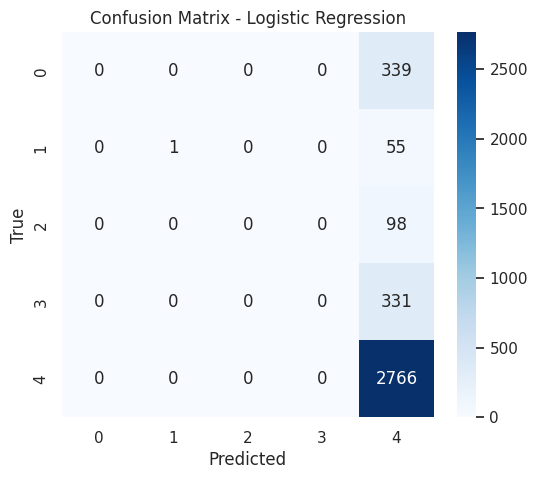

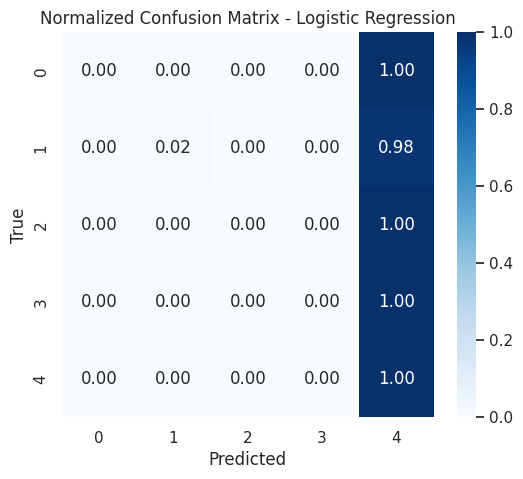

Multiclass ROC-AUC (macro): 0.5975

=== Random Forest Evaluation ===
Accuracy : 0.7766
Precision (macro): 0.3984
Recall    (macro): 0.2206
F1 Score  (macro): 0.2131

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.09      0.16       339
           1       0.50      0.02      0.03        56
           3       0.00      0.00      0.00        98
           4       0.00      0.00      0.00       331
           5       0.78      1.00      0.87      2766

    accuracy                           0.78      3590
   macro avg       0.40      0.22      0.21      3590
weighted avg       0.67      0.78      0.69      3590



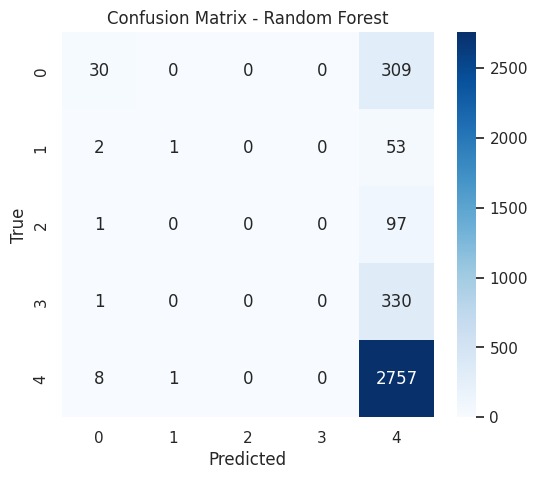

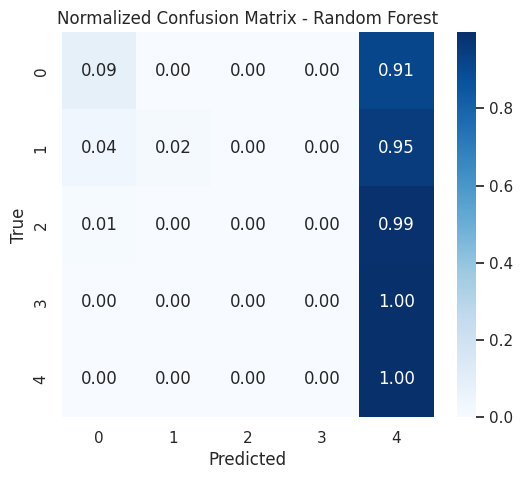

Multiclass ROC-AUC (macro): 0.6672

=== Model Comparison ===
                 Model  Accuracy  Precision    Recall        F1
0  Logistic Regression  0.770752   0.354138  0.203571  0.181117
1        Random Forest  0.776602   0.398356  0.220620  0.213107


In [24]:
# Enhanced Evaluation Function
def evaluate_model(name, model, X_test, y_test, y_pred, average="macro"):
    print(f"\n=== {name} Evaluation ===")

    # Basic metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average, zero_division=0)
    rec = recall_score(y_test, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_test, y_pred, average=average, zero_division=0)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision ({average}): {prec:.4f}")
    print(f"Recall    ({average}): {rec:.4f}")
    print(f"F1 Score  ({average}): {f1:.4f}\n")

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Confusion Matrix (raw counts)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Normalized Confusion Matrix (%)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues")
    plt.title(f"Normalized Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC Curve (for binary or multi-class with OVR)
    if hasattr(model, "predict_proba"):
        try:
            from sklearn.preprocessing import label_binarize
            classes = np.unique(y_test)
            if len(classes) == 2:
                y_score = model.predict_proba(X_test)[:,1]
                fpr, tpr, _ = roc_curve(y_test, y_score)
                auc = roc_auc_score(y_test, y_score)
                plt.figure(figsize=(6,5))
                plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
                plt.plot([0,1], [0,1], "k--")
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.title(f"ROC Curve - {name}")
                plt.legend()
                plt.show()
            else:
                y_bin = label_binarize(y_test, classes=classes)
                y_score = model.predict_proba(X_test)
                auc = roc_auc_score(y_bin, y_score, average="macro", multi_class="ovr")
                print(f"Multiclass ROC-AUC ({average}): {auc:.4f}")
        except Exception as e:
            print("ROC-AUC could not be computed:", e)

    # Return metrics in dict for comparison table
    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    }

# Evaluate both models-
results = []
results.append(evaluate_model("Logistic Regression", log_model, X_test, y_test, y_pred_log))
results.append(evaluate_model("Random Forest", rf_model, X_test, y_test, y_pred_rf))

# Summary comparison table
results_df = pd.DataFrame(results)
print("\n=== Model Comparison ===")
print(results_df)



Unnamed: 0        0.080913
comment_id        0.080311
user_id           0.078126
text              0.078045
user_name         0.076674
response_level    0.076625
user_index        0.073158
dislike_index     0.070192
created_at        0.067451
likes_score       0.064734
ranking_value     0.060757
recipe_code       0.048018
recipe_number     0.047786
recipe_name       0.047345
region            0.028027
device_type       0.021836
score_log         0.000000
vote_ratio        0.000000
user_score        0.000000
responses         0.000000
dtype: float64


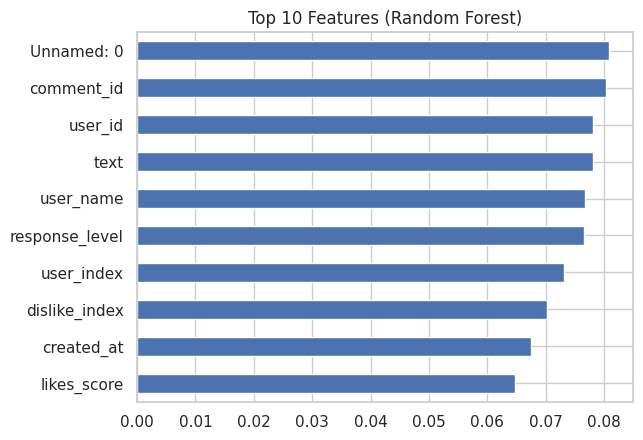

In [33]:
#Feature importances

feat_imp = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feat_imp.head(20))
feat_imp.head(10).sort_values().plot(kind='barh')
plt.title("Top 10 Features (Random Forest)")
plt.show()

/tmp/ipython-input-578647826.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=df, palette="mako")


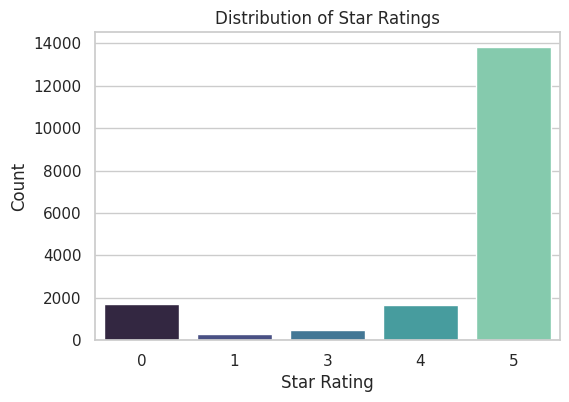

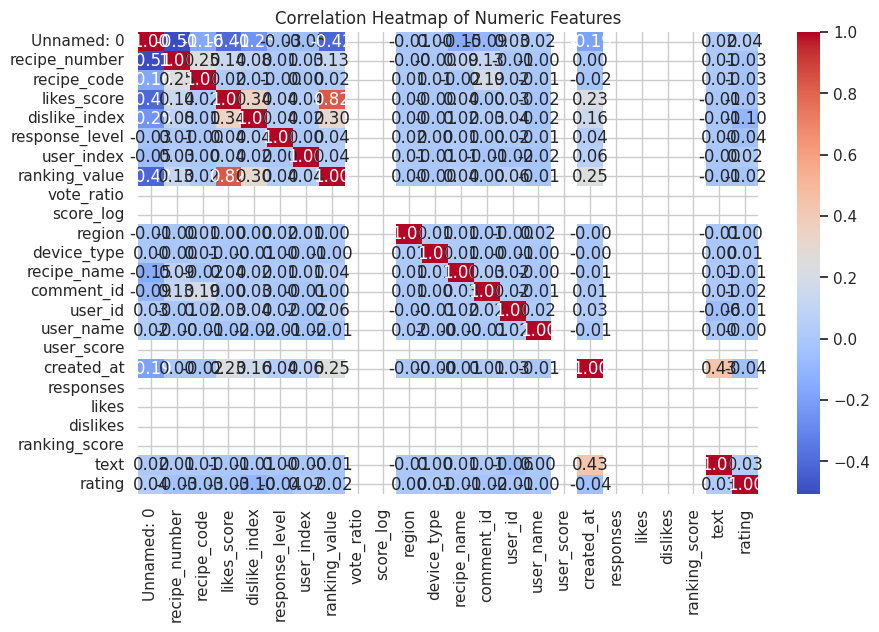

In [34]:
# Rating distribution
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=df, palette="mako")
plt.title("Distribution of Star Ratings")
plt.xlabel("Star Rating")
plt.ylabel("Count")
plt.show()

# Correlation heatmap (numeric features only)
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# Boxplot: Review length vs rating
if "review_length" in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="rating", y="review_length", data=df, palette="Set2")
    plt.title("Review Length vs. Star Rating")
    plt.xlabel("Star Rating")
    plt.ylabel("Review Length (characters)")
    plt.show()


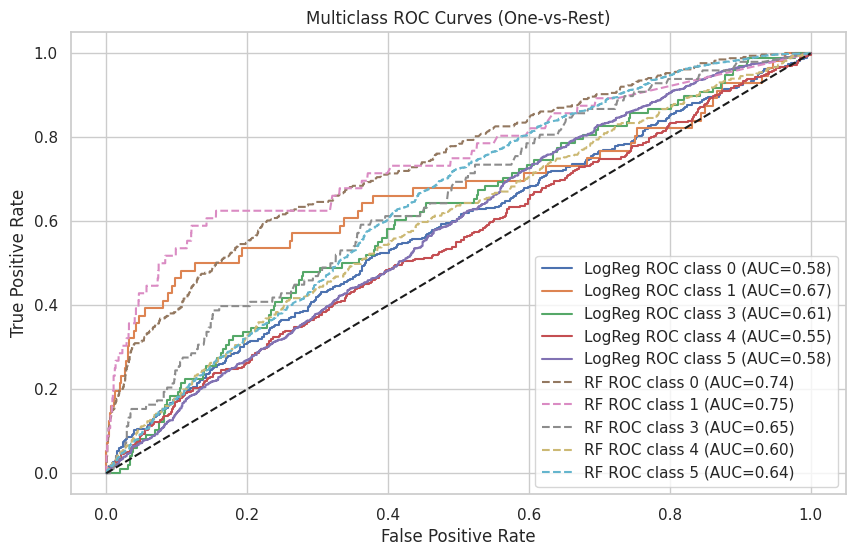

In [36]:

# Binarize labels for multiclass ROC
classes = sorted(y.unique())
y_test_bin = label_binarize(y_test, classes=classes)

# Logistic Regression OVR
ovr_log = OneVsRestClassifier(LogisticRegression(max_iter=1000))
ovr_log.fit(X_train, y_train)
y_score_log = ovr_log.predict_proba(X_test)

# Random Forest OVR
ovr_rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=200, random_state=42))
ovr_rf.fit(X_train, y_train)
y_score_rf = ovr_rf.predict_proba(X_test)

# Plot ROC curves
plt.figure(figsize=(10,6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_log[:, i])
    plt.plot(fpr, tpr, label=f"LogReg ROC class {cls} (AUC={auc(fpr, tpr):.2f})")

for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
    plt.plot(fpr, tpr, linestyle="--", label=f"RF ROC class {cls} (AUC={auc(fpr, tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.title("Multiclass ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



In [44]:

# Summary Statistics

print("\nSummary Statistics (Numeric Features):")
display(df.describe())

# Only run categorical summary if object columns exist
cat_cols = df.select_dtypes(include='object').columns
if len(cat_cols) > 0:
    print("\nSummary Statistics (Categorical Features):")
    display(df[cat_cols].describe())
else:
    print("\nNo categorical (object) columns remain after preprocessing.")




Summary Statistics (Numeric Features):


,Unnamed: 0,recipe_number,recipe_code,likes_score,dislike_index,response_level,user_index,ranking_value,vote_ratio,score_log,region,device_type,recipe_name,comment_id,user_id,user_name,user_score,created_at,responses,likes,dislikes,ranking_score,text,rating
count,17950.000000,17950.000000,17950.000000,17950.000000,17950.000000,17950.000000,17950.000000,17950.000000,17950.0,1.795000e+04,17950.000000,17950.000000,17950.000000,17950.000000,17950.000000,17950.000000,17950.0,1.795000e+04,17950.0,17950.0,17950.0,17950.0,17950.000000,17950.0
mean,112.046295,39.507799,20330.157521,0.233904,0.077589,0.000259,1.085570,108.549924,0.0,6.931472e-01,1.510975,0.996323,47.570529,9082.126797,6726.940279,6777.542061,1.0,1.622718e+09,0.0,0.0,0.0,100.0,8806.594819,4.318384
std,85.922207,29.128409,17241.797611,0.475041,0.262704,0.007111,0.610345,17.014313,0.0,1.372274e-13,1.118011,0.816352,28.971368,5244.839058,3697.643310,3930.773651,0.0,7.032666e+02,0.0,0.0,0.0,0.0,5112.154754,1.532522
min,0.000000,1.000000,386.000000,-0.805890,-0.531723,-0.018703,-0.429415,71.996204,0.0,6.931472e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.622716e+09,0.0,0.0,0.0,100.0,0.000000,0.0
25%,46.000000,13.000000,6504.000000,-0.096852,-0.100655,-0.004550,0.677358,96.785045,0.0,6.931472e-01,1.000000,0.000000,22.000000,4543.250000,3920.250000,3364.000000,1.0,1.622717e+09,0.0,0.0,0.0,100.0,4367.250000,5.0
50%,92.000000,34.000000,14600.000000,0.078158,0.027834,0.000179,1.041011,102.649502,0.0,6.931472e-01,2.000000,1.000000,46.000000,9073.500000,6367.000000,6835.500000,1.0,1.622718e+09,0.0,0.0,0.0,100.0,8804.500000,5.0
75%,150.000000,63.000000,33121.000000,0.381040,0.184909,0.004895,1.416161,113.256588,0.0,6.931472e-01,3.000000,2.000000,72.000000,13619.750000,9707.750000,10166.750000,1.0,1.622718e+09,0.0,0.0,0.0,100.0,13243.750000,5.0
max,306.000000,100.000000,73673.500000,1.103180,0.620223,0.019089,2.522836,138.129895,0.0,6.931472e-01,3.000000,2.000000,99.000000,18181.000000,13811.000000,13562.000000,1.0,1.622720e+09,0.0,0.0,0.0,100.0,17635.000000,5.0



No categorical (object) columns remain after preprocessing.


/tmp/ipython-input-2106057018.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="viridis")


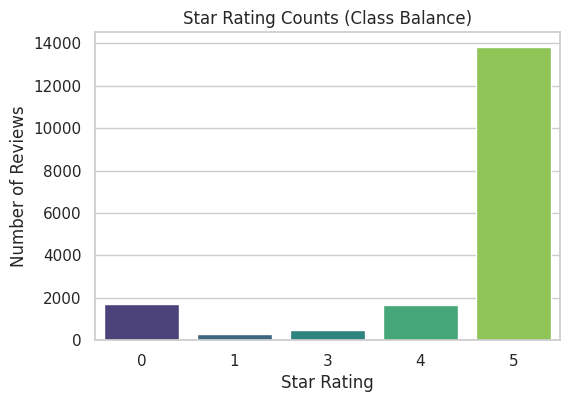

Class Distribution (%):
rating
0     9.45
1     1.56
3     2.73
4     9.22
5    77.04
Name: count, dtype: Float64


In [42]:

# Class Imbalance Check
rating_counts = df["rating"].value_counts().sort_index()
plt.figure(figsize=(6,4))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="viridis")
plt.title("Star Rating Counts (Class Balance)")
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.show()

print("Class Distribution (%):")
print((rating_counts / len(df) * 100).round(2))
